<a href="https://colab.research.google.com/github/amr1805/Brain-Tumor/blob/main/CNN_Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# The following code will only execute
# successfully when compression is complete

import kagglehub

# Download latest version
path = kagglehub.dataset_download("amr1805/brain-tumor-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/brain-tumor-dataset


<a name='T'>

<p style="padding: 20px;
          background-color: #0000FF;
          font-family: computermodern;
          color: #EEECEC;
          font-size: 300%;
          text-align: center;
          border-radius: 20px 0px;
          "> Unified CNN Approach for Multi-Class MRI Brain Tumor Classification </p>
<p style="font-family: computermodern;
          color: #000000;
          font-size: 175%;
          text-align: center;
          ">Math & Physics Fun with Gus<br>
            July 15, 2023 </p>
    
***
## <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Table of Contents <b>

1. [`About The Data`](#data)
2. [`Imports & Setup`](#imports)
3. [`Imports Data`](#import_data)
4. [`Data Visualization`](#vis)
5. [`Data Processing`](#DP)
6. [`Analysis of CNN Output`](#a_cnn)
7. [`First CNN`](#CNN)
8. [`Second CNN`](#CNN2)
10. [`End of Notebook`](#end)

Author: [Math & Physics Fun with Gus](https://mathphysicsfunwithgus.square.site)

***
<a name='data'>
  
# 1 <span style='color:blue'>|</span>  About The Data

## <b> 1.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  What is a Brain Tumor? <b>
A brain tumor refers to an abnormal collection or mass of cells within the brain. The skull, which encloses the brain, has limited space, and any growth within this confined area can lead to complications. Brain tumors can be either cancerous (malignant) or noncancerous (benign). As benign or malignant tumors grow, they can increase the pressure inside the skull. This elevated pressure can cause brain damage and pose a life-threatening risk.

### <b> 1.1.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  The Importance of Brain Tumor Classification <b>
The early detection and classification of brain tumors are crucial areas of research in medical imaging. Accurate classification aids in selecting the most suitable treatment method, potentially saving patients' lives.

### <b> 1.1.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Methods <b>
The application of deep learning approaches in healthcare has yielded significant advancements in health diagnosis. According to the World Health Organization (WHO), effective brain tumor diagnosis involves detecting the tumor, identifying its location within the brain, and classifying it based on malignancy, grade, and type. This experimental work focuses on diagnosing brain tumors using Magnetic Resonance Imaging (MRI). The process entails tumor detection, classification by grade and type, and identification of the tumor's location. Instead of employing individual models for each classification task, this method utilizes a single model for classifying brain MRI images across different classification tasks. The classification and detection of tumors employ a Convolutional Neural Network (CNN)-based multi-task approach. Additionally, a CNN-based model is employed to segment the brain and identify the location of the tumor.


## <b> 1.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  About the Dataset <b>
This dataset is a compilation of three primary datasets: figshare, Br35H, and a removed source due to bad data.

### <b> 1.2.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Dataset Description <b>
The dataset comprises a total of `7023` human **brain MRI images**, categorized into four distinct classes. The dataset focuses on brain tumors and their classification. The four classes are as follows:

**Glioma**: Cancerous brain tumors in glial cells.

**Meningioma**: Non-cancerous tumors originating from the meninges.

**No Tumor**: Normal brain scans without detectable tumors.

**Pituitary**: Tumors affecting the pituitary gland, which can be cancerous or non-cancerous.

Advancing the development of machine learning models for tumor classification is crucial for driving progress in the field of neurology and making a significant impact on the lives of individuals. These models have the potential to enhance medical research, improve diagnostic accuracy, and contribute to effective treatment strategies for various types of tumors. By leveraging machine learning techniques, we can significantly aid in the advancement of neurology and ultimately improve healthcare outcomes for people affected by tumors.
    
The "No Tumor" class images were obtained from the `Br35H dataset`.

Note: The images in this dataset have varying sizes. After pre-processing and removing excess margins, you can resize the images to the desired dimensions.

The data link and complete description here [`Brain Tumor Data on Kaggle`](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
***

<a name='imports'>

# 2 <span style='color:blue'>|</span> Importing & Setup

In [33]:
pip install --upgrade tensorflow tensorflow-io

In [34]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [35]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)


***
<a name='import_data'>
    
# 3 <span style='color:blue'>|</span> Importing Data

In [36]:
# Function for inporting data
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels


In [37]:
# Setting up file paths for training and testing
USER_PATH = r"/root/.cache/kagglehub/datasets/amr1805/brain-tumor-dataset/versions/1"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


***

<a name='vis'>
    
# 4 <span style='color:blue'>|</span> Data Visualization
    
## <b> 4.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Data Distributions <b>

Training Counts
{'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}

Testing Counts
{'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


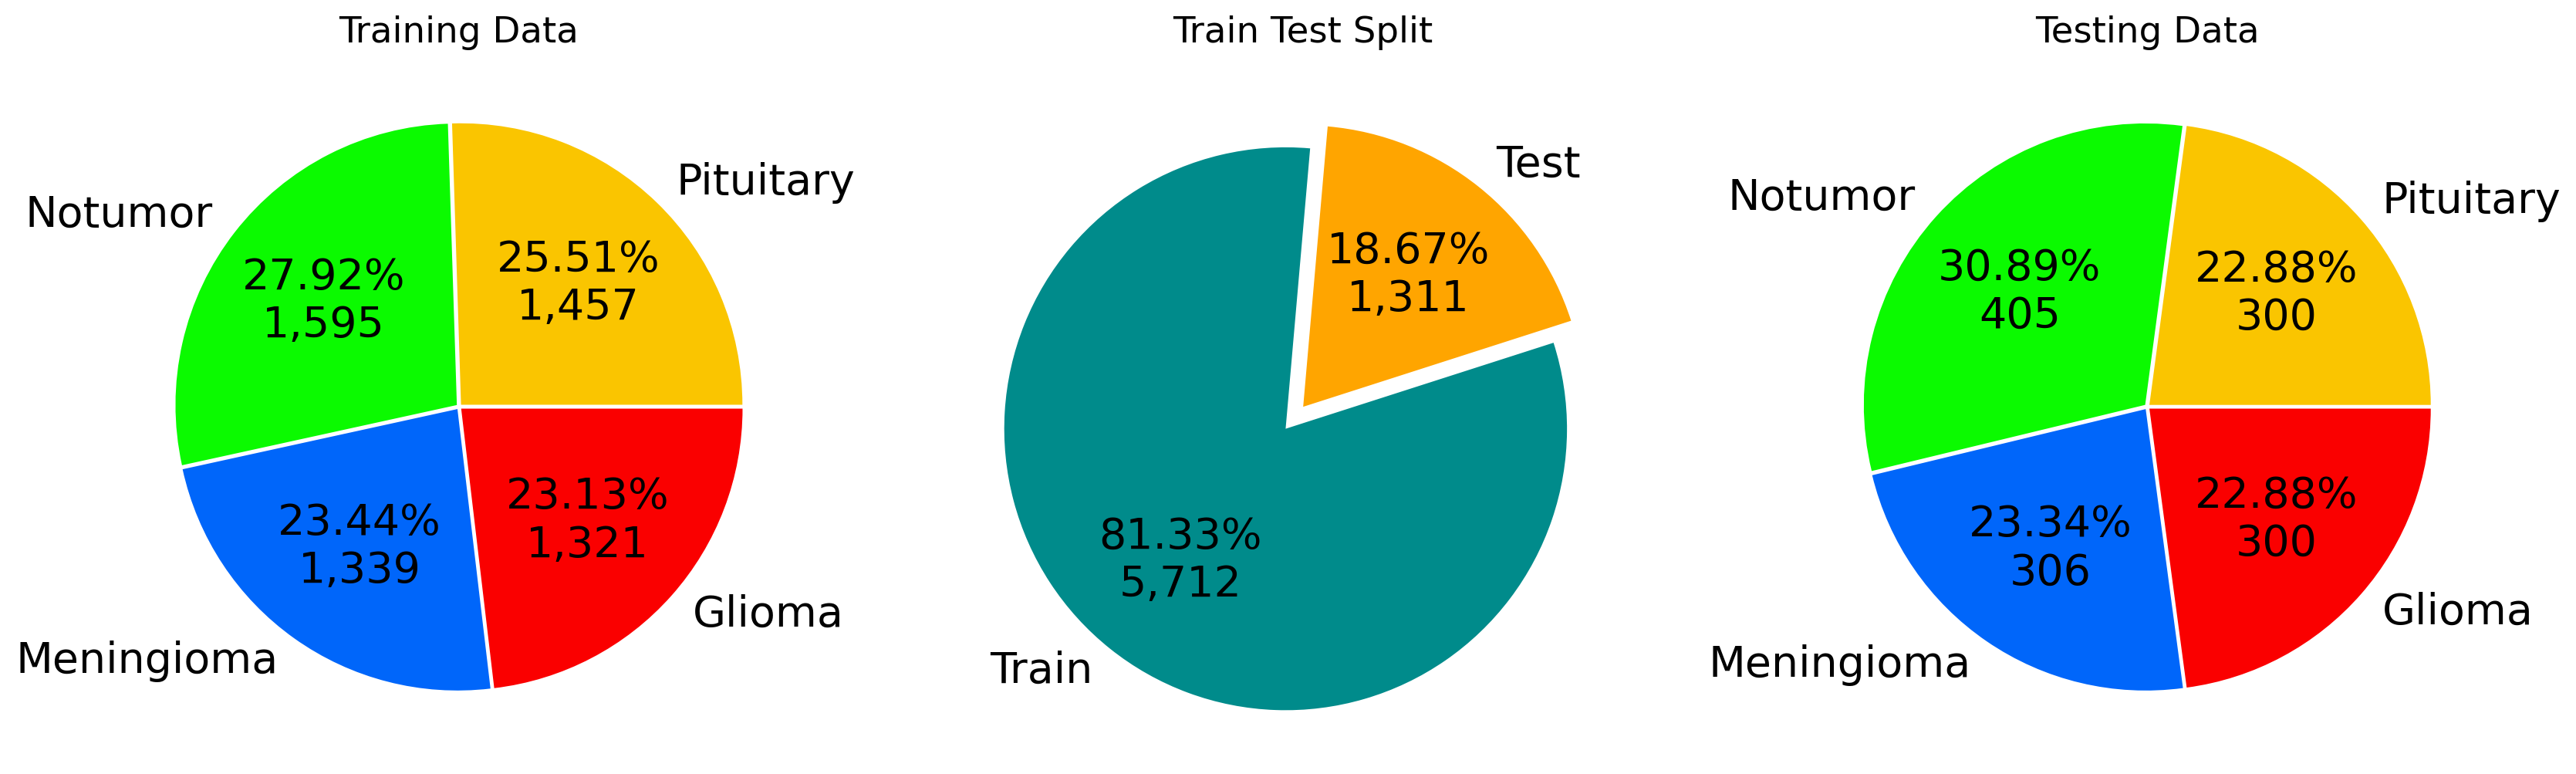

In [38]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
print('Training Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_labels), len(test_labels)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_labels), len(test_labels)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
print('\nTesting Counts')
print(dict(zip(CLASS_TYPES, class_counts)))

ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label.title() for label in CLASS_TYPES],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=tuple(0.01 for i in range(N_TYPES)),  # Explode the slices slightly for better visualization
    textprops={'fontsize': 20}  # Set the font size for the text on the pie chart
)


plt.show()

A balanced distribution of categories in our training data is crucial for optimal model learning. It allows for comprehensive understanding of each category's characteristics, prevents biases, enhances generalization, and enables iterative refinement, leading to improved performance in accurately categorizing new data.

We also have a nice split percentage in our training and testing set.

x reshaped: (1, 150, 150, 3)


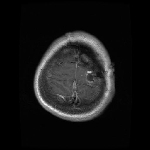

In [39]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [40]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4

    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break

        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()


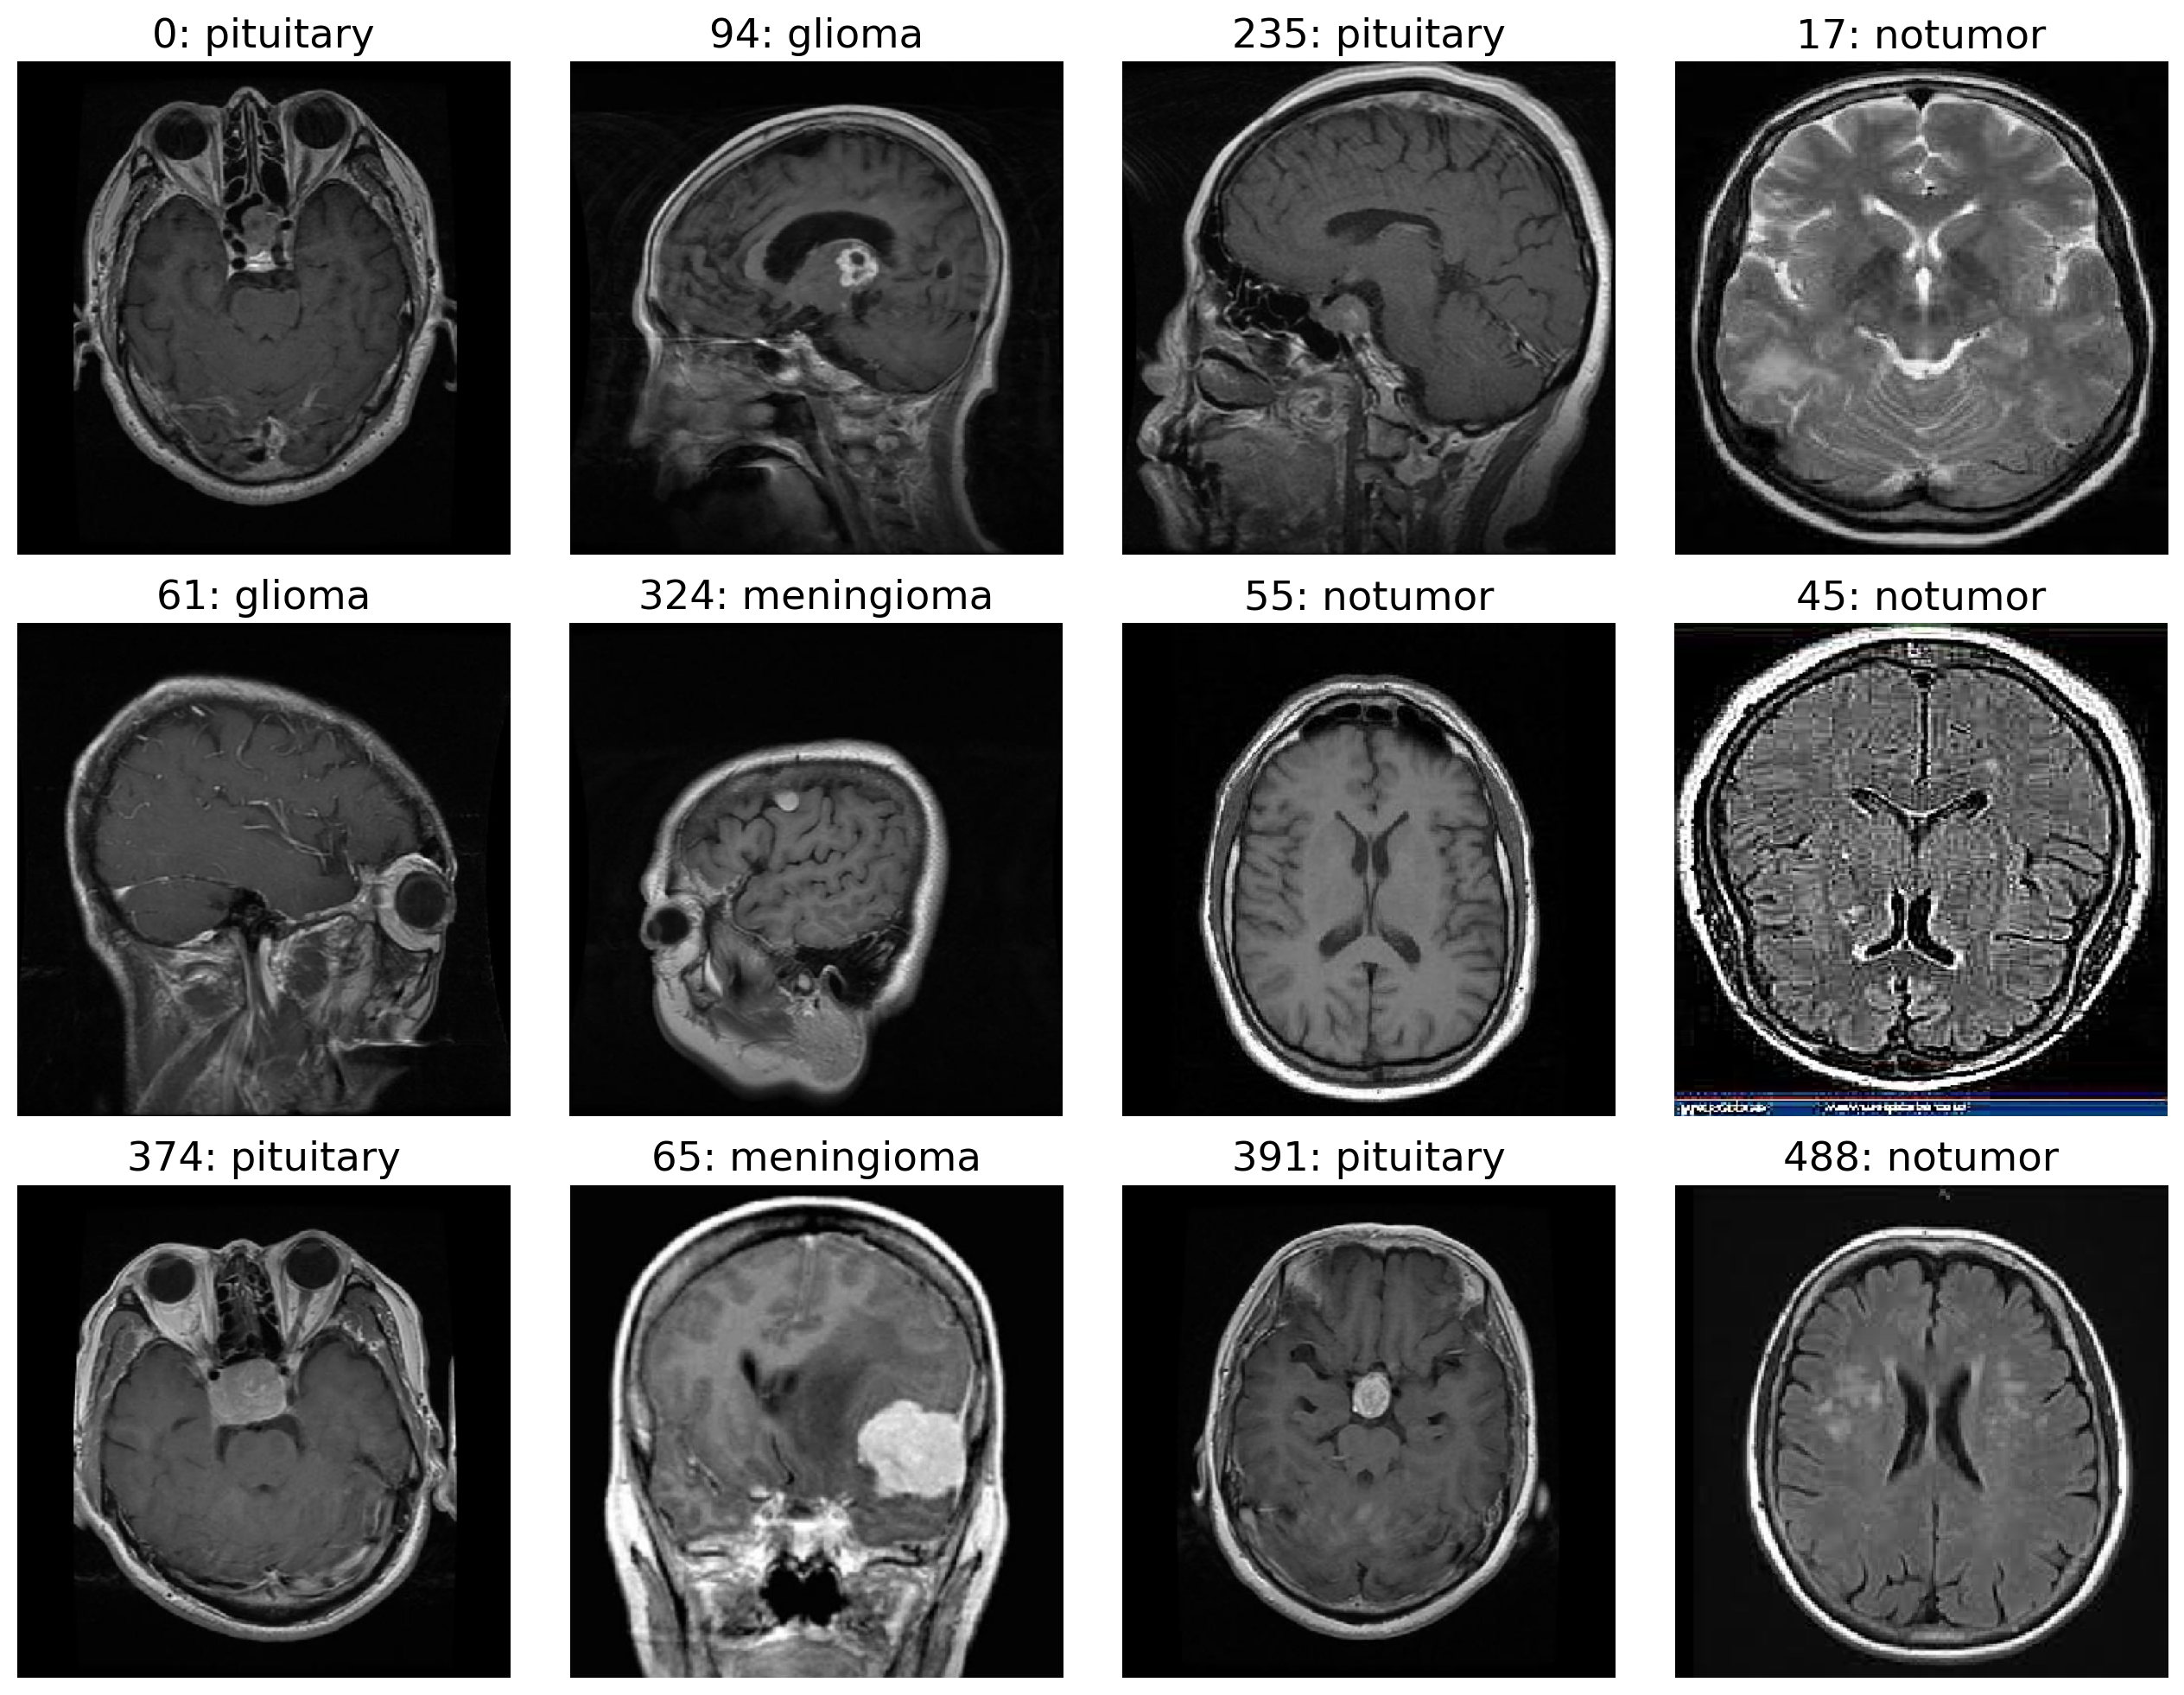

In [41]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths, train_labels, im_size=350, figsize=(13,10),
            index_list=[0, 94, 235, 17,
                        61, 324, 55, 45,
                        374, 65, 391, 488])

***
<a name='DP'>
    
# 5 <span style='color:blue'>|</span> Data Processing & Training Setup Values

In [42]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [43]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


### <b> 5.1.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Data Augmentation Class Indices <b>

In [44]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### <b> 5.1.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Showing Data Augmentation <b>

In [45]:
def show_ImageDataGenerator(image_data_generator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    augmented_samples = next(image_data_generator)

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

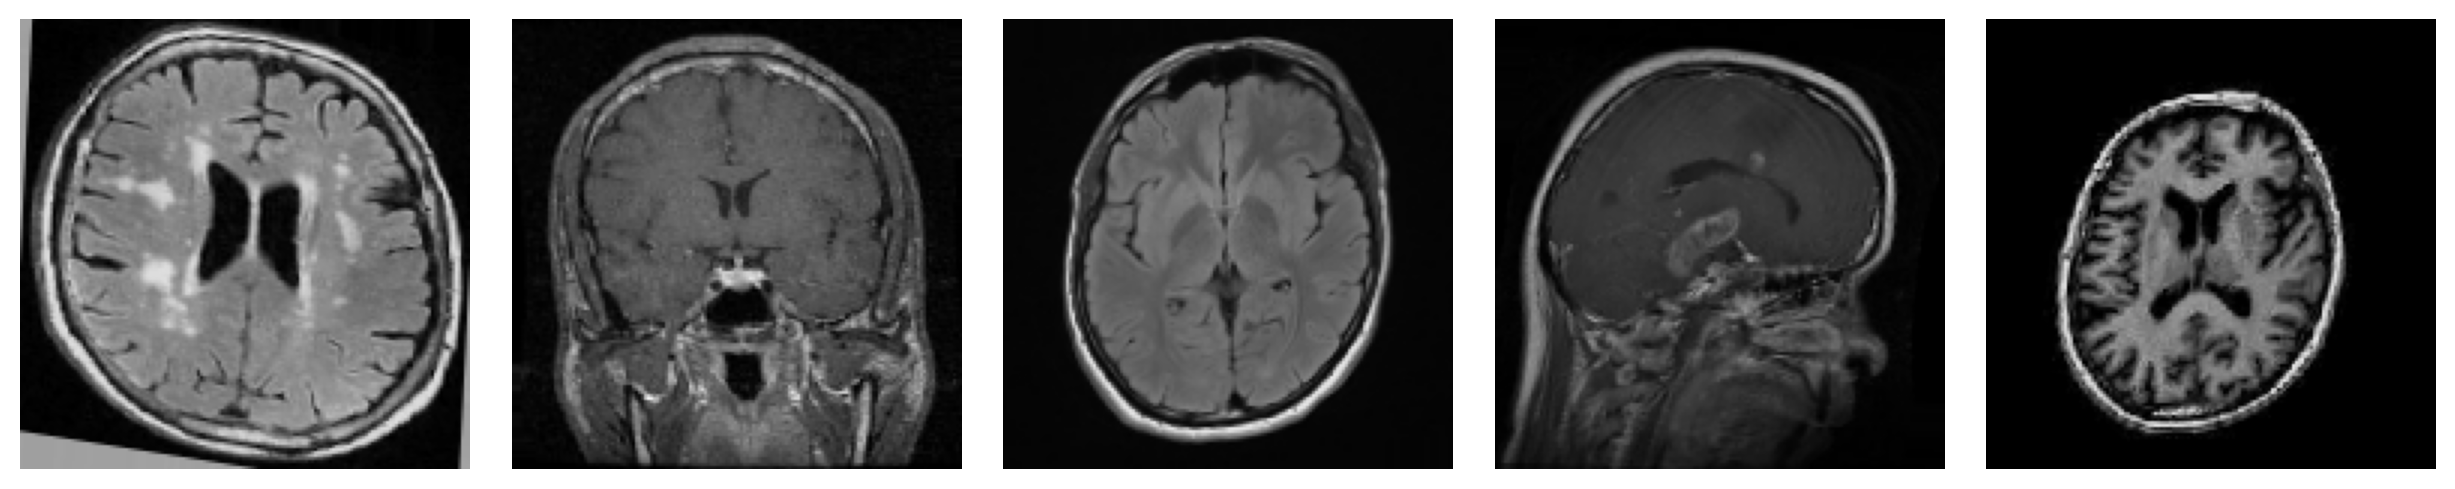

In [46]:
show_ImageDataGenerator(train_generator, num_samples=5, figsize=(12.5, 8), save=SAVE)

## <b> 5.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Training Setup Values <b>

In [47]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


***

<a name='a_cnn'>
    
# 6 <span style='color:blue'>|</span> Analysis Functions for CNN
    
## <b> 6.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>   Evaluation Metrics for Multi-Class Classification Tasks <b>

In the case of multi-class classification with four possible outputs, some of the metrics need to be adjusted. Here we explain the metrics for multi-class classification:

NOTE: In a multi-class classification problem, the concept of "True Negatives" is not applicable. True Negatives are specific to binary classification, where you have two classes (positive and negative).


A `confusion matrix` is a table that summarizes the performance of a classification model. Since we have multiple classes for us we will use it to provid a breakdown of predictions versus actual class labels for each class.

In a multi-class system we have:

- TP (True Positives): Number of instances correctly classified as a specific class.
- FP (False Positives): Number of instances incorrectly classified as a specific class, which do not actually belong to it.
- FN (False Negatives): Number of instances belonging to a specific class but incorrectly classified as other classes.


|                  | Predicted Class 1 | Predicted Class 2 | ... | Predicted Class N |
|------------------|------------------|------------------|-----|------------------|
| Actual Class 1   | True Positive (TP)   | False Positive (FP)  | ... | False Positive (FP) |
| Actual Class 2   | False Positive (FP)  | True Positive (TP)   | ... | False Positive (FP) |
| ...              | ...                | ...                | ... | ...                |
| Actual Class N   | False Positive (FP)  | False Positive (FP) | ... | True Positive (TP)  |


### <b> 6.1.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Precision <b>
Precision measures the ability of the model to correctly identify positive instances for each class among all instances predicted as positive.

For each class *c*: ``` Precision_c = TP_c / (TP_c + FP_c) ```
$$
\text{Precision}_c = \frac{{\text{TP}_c}}{{\text{TP}_c + \text{FP}_c}}
$$

### <b> 6.1.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Recall (Sensitivity or True Positive Rate) <b>
Recall calculates the ability of the model to correctly identify positive instances for each class among all actual positive instances.

For each class *c*: ``` Recall_c = TP_c / (TP_c + FN_c) ```
$$
\text{Recall}_c = \frac{{\text{TP}_c}}{{\text{TP}_c + \text{FN}_c}}
$$

### <b> 6.1.3 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  F1-Score <b>
The F1-score is the harmonic mean of precision and recall. It provides a balanced measure that combines both metrics for each class.

For each class *c*: ```F1-Score_c = 2 * (Precision_c * Recall_c) / (Precision_c + Recall_c)```
$$
\text{F1-Score}_c = 2 \times \frac{{\text{Precision}_c \times \text{Recall}_c}}{{\text{Precision}_c + \text{Recall}_c}}
$$

### <b> 6.1.4 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Accuracy <b>
Accuracy measures the overall correctness of the model's predictions across all classes.
``` Accuracy = (TP_1 + TP_2 + ... + TP_N) / (TP_1 + TP_2 + ... + TP_N + FP_1 + FP_2 + ... + FP_N + FN_1 + FN_2 + ... + FN_N) ```

$$
\text{Accuracy} = \frac{{\text{TP}_1 + \text{TP}_2 + ... + \text{TP}_N}}{{\text{TP}_1 + \text{TP}_2 + ... + \text{TP}_N + \text{FP}_1 + \text{FP}_2 + ... + \text{FP}_N + \text{FN}_1 + \text{FN}_2 + ... + \text{FN}_N}}
$$

---

In [48]:
# –––––––––––––––––––––––––––––––––––––– #
# Output Images and Labels Visualization #
# –––––––––––––––––––––––––––––––––––––– #
def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)

    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")

        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)

    plt.tight_layout()
    plt.show()


# –––––––––––––––––––––––––––––––––––––– #
#            Confusion matrix            #
# –––––––––––––––––––––––––––––––––––––– #
def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)

    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")


***
<a name='CNN'>
    
# 7 <span style='color:blue'>|</span> Initial CNN Model Tests

    From `model_1` I tested the following tuples and got the following test accuarcies. Since parameters `3.` rounded to two decimal places performed the best, or equally the best, we will use it as we improve our model.
1. filter size of `filter_size = (4, 4)` and `pool_size = (2, 2)` the accuaracy was `Test Accuracy: 0.97`
2. filter size of `filter_size = (3, 3)` and `pool_size = (3, 3)` the accuaracy was `Test Accuracy: 0.97`
3. filter size of `filter_size = (4, 4)` and `pool_size = (3, 3)` the accuaracy was `Test Accuracy: 0.98`
4. filter size of `filter_size = (3, 3)` and `pool_size = (2, 2)` the accuaracy was `Test Accuracy: 0.98`
    
Model `3.` was the tested by switched parts, then all to `model.add(AveragePooling2D(pool_size=(3, 3)))`.
- The results were good with a `Test Accuracy score: 0.9766`. But did not improve on upon the previous model.
    
Model `3.` was tested with different optimizers. The optimzer test accuracy scores were as follows.
1. Adam: `Test Accuracy: 0.982`
2. RMSprop: `Test Accuracy: 0.972`
3. Nadam: `Test Accuracy: 0.964`

In addition various trials were done to the parameters of `ImageDataGenerator()` to help ensure that overfitting would be minimized.
    
***

```python
# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(N_TYPES, activation="softmax"))

model_1.summary()

```
***

- Convolutional layer 1:
  - Input shape: (150, 150, 3)
  - Number of filters: 32
  - Filter size: (4, 4)
  - Activation function: ReLU
  - Output shape: (147, 147, 32) [Calculation: (150 - 4) + 1 = 147]

- Max Pooling layer 1:
  - Pool size: (3, 3)
  - Output shape: (49, 49, 32) [Calculation: 147 / 3 = 49]

- Convolutional layer 2:
  - Input shape: (49, 49, 32)
  - Number of filters: 64
  - Filter size: (4, 4)
  - Activation function: ReLU
  - Output shape: (46, 46, 64) [Calculation: (49 - 4) + 1 = 46]

- Max Pooling layer 2:
  - Pool size: (3, 3)
  - Output shape: (15, 15, 64) [Calculation: 46 / 3 = 15]

- Convolutional layer 3:
  - Input shape: (15, 15, 64)
  - Number of filters: 128
  - Filter size: (4, 4)
  - Activation function: ReLU
  - Output shape: (12, 12, 128) [Calculation: (15 - 4) + 1 = 12]

- Max Pooling layer 3:
  - Pool size: (3, 3)
  - Output shape: (4, 4, 128) [Calculation: 12 / 3 = 4]

- Convolutional layer 4:
  - Input shape: (4, 4, 128)
  - Number of filters: 128
  - Filter size: (4, 4)
  - Activation function: ReLU
  - Output shape: (1, 1, 128) [Calculation: (4 - 4) + 1 = 1]

- Flatten layer:
  - Reshapes the output to a 1D array of size 128.

- Dense layer 1:
  - Number of neurons: 512
  - Activation function: ReLU
  - Output shape: 512

- Dropout layer:
  - Dropout rate: 0.5
  - Output shape: 512

- Dense layer 2:
  - Number of neurons: N_TYPES (the number of output classes)
  - Activation function: Softmax
  - Output shape: N_TYPES

Total trainable parameters: 495,972 (1.89 MB)

***
<a name='CNN2'>
    
# 8 <span style='color:blue'>|</span> Final CNN Model
    
Here, we present the second version of our Convolutional Neural Network (CNN) architecture, which includes some important tweaks and additional modifications for improved performance. We have tested `BatchNormalization()` layers, which proved to be not so helpful. We also tested changing certain filter sizes such as the last `filter_size = (3,3)`. This change proved to have near no affect on the model's improvment on test accuracy.

Furthermore, we performed fine-tuning on certain hyperparameters, specifically $\beta_1$ and $\beta_2$, which are part of the Adam optimizer. By experimenting with different values, we explored a range of $\beta_1 \in [0.7, 0.995]$ and $\beta_2 \in [0.9, 0.9995]$ to optimize the training process. After conducting an exhaustive evaluation of multiple models, we achieved the highest validation accuracy with the following configuration:

**Adam Parameters:**
- `learning_rate`: The learning rate determines the step size for adjusting the model weights during training. Higher values can lead to faster convergence, but they may also risk overshooting. The default value is 0.001.
- `beta_1`: The exponential decay rate for the first moment estimates, controlling the exponential decay of the moving average of past gradients. The default value is 0.9.
- `beta_2`: The exponential decay rate for the second moment estimates, controlling the exponential decay of the moving average of past squared gradients. The default value is 0.999.
- `epsilon`: A small value added to the denominator for numerical stability. The default is 1e-7.
- `decay`: This parameter gradually decreases the learning rate over time to fine-tune the model.
- `amsgrad`: A boolean value indicating whether to use the AMSGrad variant of the Adam optimizer. The default is False.
- `clipnorm`: Caps the norm of the gradients to a specified maximum value. It provides an alternative to `clipvalue`.
- `clipvalue`: Prevents gradients from becoming too large by capping them at a specified maximum value.

Additionally, to enhance the training process and prevent overfitting, we implemented the following callbacks:

***
```python
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False, start_from_epoch=0)
ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
```
***
    
With these callbacks, the model's training will stop early if the loss stops decreasing (using `EarlyStopping`), and the learning rate will be reduced if the validation loss plateaus (using `ReduceLROnPlateau`).

These additional tweaks have improved the performance of our CNN model. Through experimentation and fine-tuning, we have achieved better convergence and higher validation accuracy.

In [31]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

# Define the model architecture
model = models.Sequential([
    Input(shape=image_shape),
    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])

model.summary()

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 1, 1, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
!pip install visualkeras

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


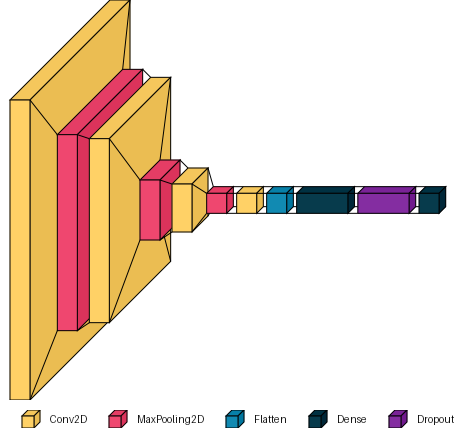

In [50]:
from visualkeras import layered_view

# Visualize the model
layered_view(model, legend=True, max_xy=300)


In [52]:
model_visual = models.Model(inputs=model.input, outputs=model.output)

# Save model architecture to a file
plot_model(model_visual, show_dtype=True, to_file='model_architecture.png', show_shapes=True)

# Display model architecture in the notebook

from IPython.display import Image
Image(retina=True, filename='model_architecture.png')

AttributeError: The layer sequential_6 has never been called and thus has no defined input.

## <b> 8.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Training Model <b>

In [53]:
# Reset the generators to ensure they are at the beginning of the dataset
train_generator.reset()
test_generator.reset()

# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.4780 - loss: 1.0719 - val_accuracy: 0.6133 - val_loss: 1.2213 - learning_rate: 0.0010
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 2:43 922ms/step - accuracy: 0.7812 - loss: 0.5263

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


178/178 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.7812 - loss: 0.5263 - val_accuracy: 0.4852 - val_loss: 1.9464 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7527 - loss: 0.5976 - val_accuracy: 0.7688 - val_loss: 0.6257 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9062 - loss: 0.2992 - val_accuracy: 0.7555 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 248s 1s/step - accuracy: 0.8240 - loss: 0.4373 - val_accuracy: 0.8195 - val_loss: 0.4329 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9688 - loss: 0.1890 - val_accuracy: 0.8109 - val_loss: 0.4535 - learning_rate: 0.0010
Epoch 7/40
 80/178 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - accuracy: 0.8567 - loss: 0.3743

KeyboardInterrupt: 

## <b> 8.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Model Evaluation <b>

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [ ]:
# Showing metrics
calculate_metrics(confusion_matrix, categories=class_indices_train_list)

In [ ]:
# Using functions in 6.1 for showing results
plot_sample_predictions(model=model,
                        test_generator=test_generator,
                        categories=class_indices_train_list,
                        test_dir=test_dir,
                        num_samples=9,
                        figsize=(13, 12))

## <b> 8.4 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Deeper Look Into Model 2 <b>

In [ ]:
# channnel map plot
def plot_channel_activation_maps(model, image, images_per_row=16, N=8, save=False):
    """
    Function to visualize how the first N layers of the model observe the input image.

    Parameters:
        model (tensorflow.keras.models.Model): The Keras model for which to visualize the activation maps.
        image (numpy.ndarray): The input image for which to generate activation maps.
        images_per_row (int): Number of activation maps to display per row in the grid.
        N (int): Number of layers to visualize.
        save (bool): If True, save the plots as PDF files.

    Returns:
        None
    """
    from tensorflow.keras.models import Model

    # Create a sub-model that outputs activations for the first N layers
    activation_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers[:N]])
    activations = activation_model.predict(image)

    # Get the names of the layers for labeling the plots
    layer_names = [layer.name for layer in model.layers[:N]]

    # Visualize the feature maps for each layer
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]
        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]
        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                epsilon = 1e-8  # A small epsilon value to avoid division by zero
                channel_std = channel_image.std() + epsilon
                channel_image /= channel_std
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

        if save:
            plt.savefig(f'plot_channel_activation_maps_{layer_name}.pdf')

    plt.show()

In [ ]:
# Get the next batch from the test generator
batch_images, batch_labels = next(test_generator)

# Extract the first image from the batch
image, label = batch_images[0], batch_labels[0]
image_tensor = np.expand_dims(image, axis=0)

# Get the class indices from the test generator
class_indices = test_generator.class_indices

# Convert the one-hot encoded label to the class name
label_name = [k for k, v in class_indices.items() if np.argmax(label) == v][0]

# Display the class name
print(f"Class name of the first image: {label_name}")
print(f'Shape {image_tensor.shape}')
array_to_img(image_tensor[0])

In [ ]:
plot_channel_activation_maps(model=model, image=image_tensor, N=5, save=SAVE)

### <b> 8.4.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Misclassified Tumors <b>

In [ ]:
# Visualization of mis-classsified images
def visualize_misclassified_images(model, test_generator, class_indices):
    """
    Visualize misclassified images from the test set alongside their predicted and true labels.

    Parameters:
        model (tensorflow.keras.models.Model): The trained Keras model.
        test_generator (tensorflow.keras.preprocessing.image.DirectoryIterator): The test data generator.
        class_indices (dict): Dictionary mapping class names to their corresponding integer labels.

    Returns:
        None
    """

    from tensorflow.keras.preprocessing.image import array_to_img

    misclassified_images = []
    misclassified_labels_true = []
    misclassified_labels_pred = []

    for i in range(len(test_generator)):
        batch_images, batch_labels = next(test_generator)
        batch_predictions = model.predict(batch_images, verbose=False)
        predicted_labels = [list(class_indices.keys())[np.argmax(pred)] for pred in batch_predictions]
        true_labels = [list(class_indices.keys())[np.argmax(label)] for label in batch_labels]

        for j in range(len(batch_images)):
            if predicted_labels[j] != true_labels[j]:
                misclassified_images.append(batch_images[j])
                misclassified_labels_true.append(true_labels[j])
                misclassified_labels_pred.append(predicted_labels[j])

    # Display misclassified images alongside their true and predicted labels
    num_misclassified = len(misclassified_images)
    num_rows = int(np.ceil(num_misclassified / 4))
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_misclassified):
        plt.subplot(num_rows, 4, i + 1)
        plt.title(f"True: {misclassified_labels_true[i]}\nPred: {misclassified_labels_pred[i]}", color='red')
        plt.imshow(array_to_img(misclassified_images[i]))
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Using function above
visualize_misclassified_images(model, test_generator, test_generator.class_indices)

<a name='end'>
    
***
0. [`Return To Top of Notebook`](#T)
1. [`About The Data`](#data)
2. [`Imports & Setup`](#imports)
3. [`Imports Data`](#import_data)
4. [`Data Visualization`](#vis)
5. [`Data Processing`](#DP)
6. [`Analysis of CNN Output`](#a_cnn)
7. [`First CNN`](#CNN)
8. [`Second CNN`](#CNN2)
9. [`End of Notebook`](#end)

Author: [Math & Physics Fun with Gus](https://mathphysicsfunwithgus.square.site)

<p style="padding: 10px;
          background-color: yellow;
          font-family: computermodern;
          color: black;
          font-size: 210%;
          text-align: center;
          border-radius:20px 20px;
          ">Thank you and if you found this useful please like 👍🏼 </p>
    
# <b> END <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Jupyter Notebook <b>
***